In [61]:
import seaborn as sns
sns.set(rc={'axes.facecolor': 'dimgrey', 'grid.color': 'lightgrey'})
import pandas as pd
import torch
import copy
import matplotlib.pyplot as plt

In [68]:
%run utils.ipynb
%run model.ipynb

In [55]:
# class 1 is illicit, 2 is licit, unknown is unknown
labels = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
edges = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
nodes = pd.read_csv("data/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)

In [56]:
indexes = labels.index[labels["class"] != "unknown"].tolist()
labels_new = labels[labels["class"] != "unknown"]
nodes_new =  nodes.take(indexes)
edges_new = edges.loc[edges["txId1"].isin(labels_new["txId"])].loc[edges["txId2"].isin(labels_new["txId"])]
nodes_new.shape, labels_new.shape, edges_new.shape

((46564, 167), (46564, 2), (36624, 2))

In [57]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [58]:
data, graph_info = time_step_split(nodes_new, edges_new, labels_new, device)
for key in data:
    print(key, len(data[key]))

train 31
val 5
test 13


In [69]:
model = GNN_Example(data["train"][0].x.shape[1], 1, 2, 256, 3, K=2, dropout_rate=0.1).to(device)

In [72]:
model.reset_parameters()

lr = 1e-2
epochs = 50
weight = torch.tensor([0.9, 0.1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.NLLLoss(weight)

best_model = None
best_valid_auc = 0
best_result = None
losses = []

for epoch in range(1, 1 + epochs):
    # train with random split
    loss = train(model, data['train'], optimizer, loss_fn, device)
    losses.append(loss)
    result = test(model, data, device)
    train_acc, val_acc, test_acc, train_auc, val_auc, test_auc = result
    if val_auc > best_valid_auc:
        best_valid_auc = val_auc
        best_model = copy.deepcopy(model)
        best_result = [train_acc, val_acc, test_acc, train_auc, val_auc, test_auc]
    if epoch % 10 == 0:
        print('Epoch: {:02},'.format(epoch),
              'Loss:{:.4f}'.format(loss),
              'Train:\n{}\n'.format(train_acc),
              'Train_auc_roc: {}'.format(train_auc),
              '\n\n'
              'Valid:\n{}\n'.format(val_acc),
              'Val_auc_roc: {}'.format(val_auc),
              '\n\n'
              'Test:\n{}\n'.format(test_acc),
              'Test_auc_roc: {}'.format(test_auc),
              '\n'
              )

Epoch: 10, Loss:0.3364 Train:
                   0           1  accuracy   macro avg  weighted avg
precision   0.481123    0.985014  0.901516    0.733069      0.936047
recall      0.776208    0.892958  0.901516    0.834583      0.901516
f1-score    0.583079    0.935249  0.901516    0.759164      0.910893
support    98.709677  792.096774  0.901516  890.806452    890.806452
 Train_auc_roc: 0.8345830701176352 

Valid:
                    0           1  accuracy    macro avg  weighted avg
precision    0.268851    0.990983  0.770374     0.629917      0.923756
recall       0.942556    0.741149  0.770374     0.841852      0.770374
f1-score     0.403109    0.845517  0.770374     0.624313      0.814838
support    123.400000  942.200000  0.770374  1065.600000   1065.600000
 Val_auc_roc: 0.8418521836360087 

Test:
                   0           1  accuracy    macro avg  weighted avg
precision   0.168125    0.981644  0.683765     0.574885      0.933664
recall      0.758780    0.676186  0.683765   

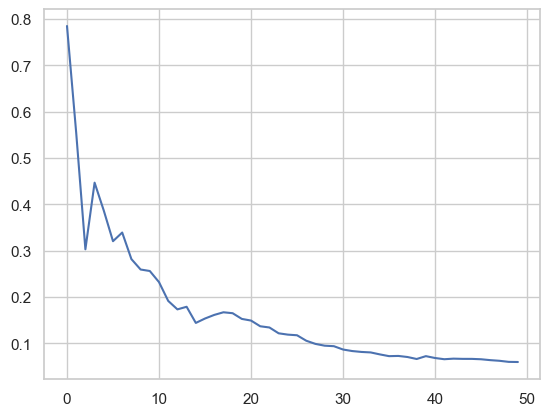

In [71]:
plt.plot(losses)
plt.show()